# Chapter 2 Practical

## Zero mean white noise autocovariance

In [1]:
import numpy as np

In [2]:
rng = np.random.default_rng(9)  # 9 is seed

In [3]:
def random_array_zero_center(bound, length):
    """
    :param bound: generates random values from [-bound, bound]
    :param length: array length to generate
    """
    return 2 * bound * rng.random(length) - bound

In [4]:
white_noise_64 = random_array_zero_center(1, 64)
print(white_noise_64[:10])
np.average(white_noise_64)

[ 0.74049841 -0.42636558  0.2062963   0.55506817  0.43214926  0.83076024
  0.7207873   0.83647526 -0.94682453 -0.125504  ]


0.073580576380466

In [5]:
white_noise_512 = random_array_zero_center(1, 512)
np.average(white_noise_512)

-0.008048000979764233

In [6]:
white_noise_4096 = random_array_zero_center(1, 4096)
np.average(white_noise_4096)


0.0005339755126787786

Mean approaches zero as the length of the random sequence increases.

In [7]:
import statsmodels.api as sm

In [8]:
def autocovariance(sequence):
    return sm.tsa.stattools.acovf(sequence, fft=False)

autocov_64 = autocovariance(white_noise_64)
autocov_512 = autocovariance(white_noise_512)
autocov_4096 = autocovariance(white_noise_4096)

In [9]:
import matplotlib.pyplot as plt
from scipy import stats

DescribeResult(nobs=64, minmax=(-0.10034152318752937, 0.3778419096642083), mean=0.002951889919251627, variance=0.0035343757692085837, skewness=3.82277488406955, kurtosis=22.98239428497803)

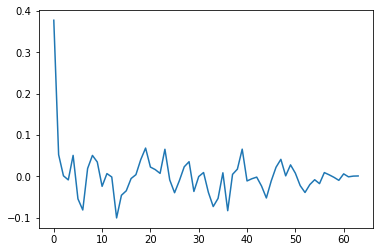

In [10]:
plt.plot(autocov_64)
stats.describe(autocov_64)

DescribeResult(nobs=512, minmax=(-0.04163661216857269, 0.3128923926938585), mean=0.00030555897724009613, variance=0.00028983194585480577, skewness=12.055263062972754, kurtosis=220.39956894010007)

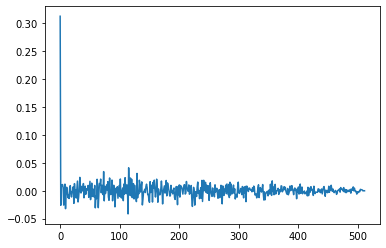

In [11]:
plt.plot(autocov_512)
stats.describe(autocov_512)

DescribeResult(nobs=4096, minmax=(-0.01451565218517448, 0.3214027395205685), mean=3.923373285163184e-05, variance=3.7841434758737304e-05, skewness=34.811760853252295, kurtosis=1816.7431575109345)

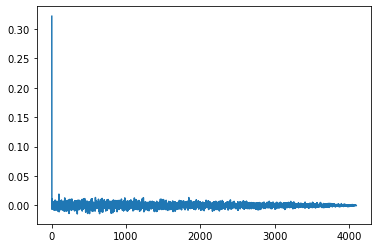

In [12]:
plt.plot(autocov_4096)
stats.describe(autocov_4096)

As expected, the mean and variance of the autocovariance sequence approach zero as sequence length increases.

## Autocovariance of EEG

In [13]:
import os
import mne

### Loading and Preprocessing

Because the OpenBCI RAW format is not supported by mne, we must manually read the data into an array.

*Future reference: Record from OpenBCI GUI in the BDF format rather than RAW.*

In [14]:
with open(os.path.join('..', '..', '..', 'data', 'self-recorded', 'eog-noise', '8blinks_OpenBCI-RAW-2021-02-05_10-05-32.txt'), 'r') as eog_noise_file:
    eog_noise_lines = eog_noise_file.readlines()

eog_noise_samples = eog_noise_lines[6:]  # skip to first data sample

fp1 = []
for sample in eog_noise_samples:
    fp1.append(float(sample.split(',')[3]))

fp1_electrode = np.array([fp1]) * 1e-6  # convert to volts
del fp1

print(fp1_electrode[:10])

[[0.04104437 0.04138571 0.0413746  ... 0.04202548 0.04183071 0.04209271]]


Now we may create an MNE info object with some information about our data.

In [15]:
samp_freq = 250
channel_types = ['eeg']
channel_names = ['fp1']
info = mne.create_info(ch_names=channel_names, sfreq=samp_freq, ch_types=channel_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: fp1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>

Note that the mne info object sets a lowpass filter at half of the sample frequency (125 Hz).

In [16]:
raw = mne.io.RawArray(fp1_electrode, info)

Creating RawArray with float64 data, n_channels=1, n_times=5651
    Range : 0 ... 5650 =      0.000 ...    22.600 secs
Ready.


Effective window size : 8.192 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-17-bebfffa0df26>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  line_noise_fig = raw.plot_psd()


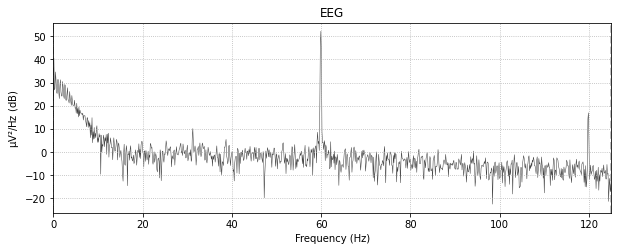

In [17]:
line_noise_fig = raw.plot_psd()

With the PSD plot, we see the significant power line noise at 60Hz and the 120Hz harmonic. Let's remove it with a notch
filter.

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Effective window size : 8.192 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-18-5f4f053aff66>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  no_line_fig = raw.plot_psd()


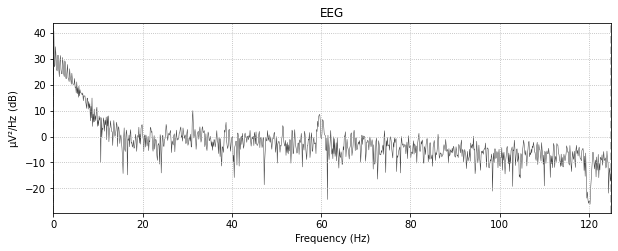

In [18]:
raw.notch_filter(freqs=(60, 120))
no_line_fig = raw.plot_psd()

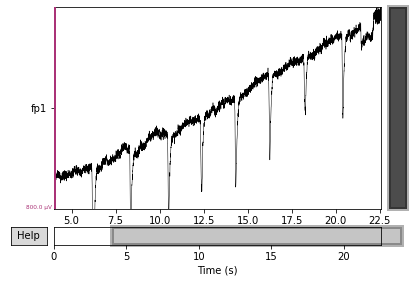

In [19]:
drift_fig = raw.plot(duration=20, start=4, scalings=dict(eeg=400e-6), remove_dc=True)

You can see we are also dealing with significant DC drift, even when MNE automatically tries to remove DC before plotting.
We can add a highpass at .5 Hz to counteract the drift.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 1651 samples (6.604 sec)



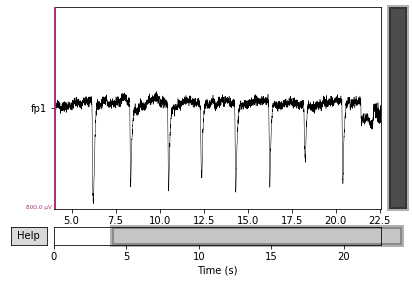

In [20]:
raw.filter(l_freq=.5, h_freq=124)  # using bandpass but serves as highpass
no_drift_fig = raw.plot(duration=20, start=4, scalings=dict(eeg=400e-6))

### Autocovariance

In [21]:
preprocessed_data = raw.get_data(start=(4 * samp_freq))
print(preprocessed_data)
preprocessed_data = preprocessed_data[0]  # only one channel Fp1
preprocessed_data

[[-7.64846595e-06  6.97213404e-07  1.22631210e-06 ... -3.50689315e-05
  -2.16120861e-05  6.93889390e-18]]


array([-7.64846595e-06,  6.97213404e-07,  1.22631210e-06, ...,
       -3.50689315e-05, -2.16120861e-05,  6.93889390e-18])

DescribeResult(nobs=4651, minmax=(-0.00038199168081254125, 6.311024404409386e-05), mean=-1.7760981805687748e-06, variance=3.4831814689237016e-09, skewness=-3.527674916058037, kurtosis=13.737754351864105)


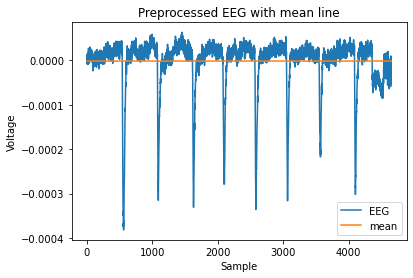

In [22]:
eeg_stats = stats.describe(preprocessed_data)
print(eeg_stats)
eeg_mean = eeg_stats.mean
mean_line = np.array([eeg_mean] * len(preprocessed_data))
plt.plot(preprocessed_data, label="EEG")
plt.plot(mean_line, label="mean")
plt.xlabel("Sample")
plt.ylabel("Voltage")
plt.title("Preprocessed EEG with mean line")
plt.legend()
plt.show()

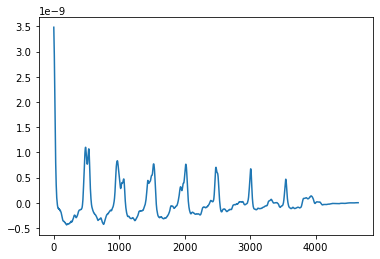

In [23]:
fp1_autocov = autocovariance(preprocessed_data)
plt.plot(fp1_autocov)

In [24]:
stats.describe(fp1_autocov)

DescribeResult(nobs=4651, minmax=(-4.408299366796992e-10, 3.4824325586960252e-09), mean=3.743746031709313e-13, variance=1.0866887657925314e-19, skewness=3.480758601594628, kurtosis=23.79808026828215)